In [1]:
## Python Libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import joblib
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
import plotly.offline as py
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pandas.plotting import lag_plot
from pandas.plotting import scatter_matrix
from pandas.plotting import autocorrelation_plot
from pylab import rcParams
from pandas import DataFrame
from pandas import concat
import seaborn as sns

In [2]:
pd.set_option('display.max_columns',None)
%matplotlib inline
warnings.filterwarnings("ignore")
py.init_notebook_mode()
rcParams['figure.figsize'] = 15, 10

In [3]:
## All Config Settings
TESTING_YEAR                = 2017
TRAINING_YEAR_LIST          = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

DATA_FILE                   = '/Users/kaustavsaha/startup_project/Project/data/Data.csv'

# Hyper-Parameter Tuning
# CHANGEPOINTS(timeslot where Sudden and Abrupt changes occured in the trend) => From the literature survey, 
        # I have concluded that automatic detection by Prophet allows the trend to adapt appropriately.

############################################################################################
####     Parameter  ####
CHANGEPOINT_RANGE           = 0.95 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .1 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
        
NUMBER_OF_DAYS_TESTING_YEAR = 365

In [38]:
def data_read(data_path):
    '''
    To read data into Pandas DF
    Args:
        data_path (str): Data location
    
    Returns:
        df (DF): Data frame 
    '''
    df = pd.read_csv(data_path)
    print(' #### Initial Data Load ####')
    print(df.head(5))
    return(df)

In [5]:
def date_time_formatter(date):
    
    date_str      = str(date)
    date_str_list = date_str.split('/')
    
    month = str(date_str_list[0])
    day   = str(date_str_list[1])
    year  = str(date_str_list[2])
    
    date_format = year + '-' + month + '-' + day
    
    return(date_format)

In [6]:
def date_time_feature_extractor(date,n):
    date_str      = str(date)
    date_str_list = date_str.split('/')
    data_parser   = int(date_str_list[n])
    return(data_parser)

In [7]:
def data_augmentation(df):
    df['Month']        = df.date.apply(lambda x : date_time_feature_extractor(x,0))
    df['Day']          = df.date.apply(lambda x : date_time_feature_extractor(x,1))
    df['Year']         = df.date.apply(lambda x : date_time_feature_extractor(x,2))
    df['Date_Format']  = df.date.apply(lambda x : date_time_formatter(x))
    df['Date_Format']  = pd.to_datetime(df['Date_Format'])
    df['Day_of_Week']  = df['Date_Format'].dt.dayofweek
    print('#####   Augmented Data  ########')
    print(df.head(5))
    Master = df
    return(Master, df)

In [8]:
def test_data_preparation(Master):
    test_data = Master[Master.Year.isin([TESTING_YEAR])]
    test_data = test_data.sort_values(by=['Year','Month','Day'])
    test_data = test_data[['station_id','date','rides']]
    
    print(' ###### Test Data Preparation ######')
    print(test_data.shape)
    print(test_data.head(5))
    return(test_data)

In [9]:
def data_segmentor(df):
    print(' ###### Training Data Preparation ######')
    df    = df[df.Year.isin(TRAINING_YEAR_LIST)]
    print(df.shape)
    print(df.head(5))
    return(df)

In [10]:
def basic_data_structure_exploration(df):
    
    print('#########  Data Shape  #########')
    print(df.shape)
    print('#########  Data Head   ##########')
    print(df.head())
    print('#########  Data Types   ##########')
    print(df.dtypes)
    print('######### Day Type Values ########')
    print(df.daytype.unique())
    print('########  Total number of NaN  ######')
    print(df.isna().sum())
    print('######### Number of Unique Station Id #######')
    print(df.station_id.nunique())
    print('########  Number of Unique Station Name  ######')
    print(df.stationname.nunique())
    

In [11]:
def station_num_zeroes(Master):

    Station_Missing_Values = {}

    total_stations = np.array(Master.stationname.unique()).tolist()

    for station in total_stations :
        individual_station = Master[(Master['stationname'] == station)]
    
        individual_station_rider = individual_station[['rides']]
        num_zero = individual_station_rider[individual_station_rider == 0].count(axis=0)
        Station_Missing_Values[station] = num_zero[0]
    
    Station_Missing_Values = pd.DataFrame(Station_Missing_Values.items(), columns = ['Station','Num_Zeroes'])
    Station_Missing_Values = Station_Missing_Values.sort_values(by=['Num_Zeroes'], ascending = False)
    
    print(' ####### Top 20 Stations with Maximum Missing Values    ####### ')
    print(Station_Missing_Values.head(20))

In [12]:
def missing_value_analysis(Master):

    Station_Missing_Values = {}

    total_stations = np.array(Master.stationname.unique()).tolist()

    # HACK - Select subset (sampled data) for faster testing
    total_stations = total_stations[0:20]

    df_row_list   = []

    for station in total_stations :
        df_col_list = []
        for year in TRAINING_YEAR_LIST :
            individual_station = Master[(Master['stationname'] == station) & (Master['Year'] == year)]
            individual_station_rider = individual_station[['rides']]
            num_zero = individual_station_rider[individual_station_rider == 0].count(axis=0)
        
            data = {str(year):[int(num_zero[0])]}
            df_i = pd.DataFrame(data)
            df_i.index = [station]
        
            df_col_list.append(df_i)
        
        df_row = pd.concat(df_col_list, axis = 1)
        df_row_list.append(df_row)

    Full_df = pd.concat(df_row_list, axis = 0)
    print(Full_df.head(20))

    ## Identifying Heat Maps showing stations which have the maximum number of zeroes
    ## Servicability, Maintainence could be the issue
    
    ## Since HeatMaps are getting overlapped please uncomment for heatmap generation
    ## sns.heatmap(Full_df, annot=True)

In [13]:
def total_ride_analysis(Master):

    total_stations = np.array(Master.stationname.unique()).tolist()

    # HACK - Select subset(sampled data) for faster testing
    total_stations = total_stations[0:20]

    df_row_list   = []

    for station in total_stations :
        df_col_list = []
        for year in TRAINING_YEAR_LIST :
            individual_station = Master[(Master['stationname'] == station) & (Master['Year'] == year)]
            individual_station_rider = individual_station[['rides']]
            num = individual_station_rider.sum(axis=0)
        
            data = {str(year):[int(num[0])]}
            df_i = pd.DataFrame(data)
            df_i.index = [station]
        
            df_col_list.append(df_i)
        
        df_row = pd.concat(df_col_list, axis = 1)
        df_row_list.append(df_row)

    Full_df = pd.concat(df_row_list, axis = 0)
    print(Full_df.head(20))

    ## Identifying Heat Maps showing stations which have the maximum number of riders
    ## might have to concentrate on capacity planning
    sns.heatmap(Full_df, annot=True)

In [14]:
## Total Rides Across Years
def total_rides_across_years(df):
    df_year_rides  = pd.DataFrame(df.groupby('Year')['rides'].sum())
    df_year_rides.plot(kind = 'bar', title = 'Total Rides in millions across years')

In [15]:
## Busiest Stations
def top_total_rides_across_stations(df):
    print(df.columns)
    total_station_rides  = pd.DataFrame(df.groupby(['station_id','stationname'])['rides'].sum())
    total_station_rides    = total_station_rides.sort_values('rides', ascending = False)
    top_station_rides = total_station_rides.head(10)
    print(top_station_rides)
    top_station_rides.plot(kind = 'bar', ylim = (50000000, 100000000) , title = 'Top Stations with Total Rides (millions)')

In [16]:
## Station Count Across Years
def station_count(df):
    df_station_count  = pd.DataFrame(df.groupby('Year').station_id.nunique())
    df_station_count.plot(kind = 'bar', ylim = (140,146) , title = 'Total Number of Stations across years')

In [17]:
def basic_data_visualization(df):
    total_rides_across_years(df)
    top_total_rides_across_stations(df)
    station_count(df)

In [18]:
def zero_ride_station_date_analysis(df):
    
    print('##########################################')
    print('###### Stations with zero ridership cannot be used for any Time-Series Modelling') 
    station  = pd.DataFrame(df.groupby(['station_id'])['rides'].agg('sum'))
    print(station.query('rides == 0'))

In [19]:
def Imputation(Master):

    Total_Rows = len(Master.index)
    Total_num_zero_rides = Master[Master.rides == 0].count(axis=0)
    Total_num_zero_rides = Total_num_zero_rides['rides']

    print('percentage of Total missing values = ',round((Total_num_zero_rides/Total_Rows*100),2),'%')

    Replaced_Master = Master
    
    ### Imputation of Zero Rides with None as Prophet will take care of missing values
    Replaced_Master = Replaced_Master.replace(0,None)
    
    Total_Replaced_num_zero_rides = Replaced_Master[Replaced_Master.rides == 0].count(axis=0)
    Total_Replaced_num_zero_rides = Total_Replaced_num_zero_rides['rides']

    print('After Replacement percentage of Total missing values = ',round((Total_Replaced_num_zero_rides/Total_Rows*100),2),'%')
    
    return(Replaced_Master)

In [20]:
def data_pre_processing(df):
    Imputed_df = Imputation(df)
    return(Imputed_df)

In [34]:
## Temporal Structure Analysis of Time-Series with Lag Plot and Autocorrelation Plot

def extra_visualization_diagnostics(model_data):
    
    ## Single Lag Plot
    series = pd.Series(model_data['rides'].values)
    lag_plot(series)
    plt.show()
  
    ###############
    
    ### Auto Correlation Plots
    #autocorrelation_plot(series)
    #plt.show()

In [22]:
def model_data_creator(df):

    Model_Data_Repository = {}
    
    total_stations = df.station_id.unique()
    
    ## HACK  -- to be removed -- For running the script for testing
    total_stations = total_stations[0:1]
    print("######## Stations under Investigation  ##############")
    print(total_stations)
    
    for individual_station in total_stations :
        model_data = df[(df['station_id'] == individual_station)]
        model_data = model_data.sort_values(by=['Year','Month','Day'])
        model_data = model_data[['date','rides']]
        extra_visualization_diagnostics(model_data)
        Model_Data_Repository[individual_station] = model_data
     
    return(Model_Data_Repository)

In [23]:
## Holiday List - Deciphered from the Data
## New Year's Day    
## Memorial Day
## Independence Day
## Labor Day
## Thanksgiving Day
## Christmas Day

def holiday_preparator(Master, station_id):

    Master_Holiday_List = []

    for year in TRAINING_YEAR_LIST:
        holiday_list = Master[(Master['station_id'] == station_id) 
                        & (Master['Year'] == year) 
                        & (Master['daytype'] == 'U')
                        & (Master['Day_of_Week'] != 6)]

        holiday_list = holiday_list.sort_values(by=['Year','Month','Day'])
        holiday_dates = holiday_list['Date_Format']

        for date in holiday_dates:
            date_str = str(date)
            date_str = date_str[0:10]
            Master_Holiday_List.append(date_str)
        
    holidays_data = pd.DataFrame({
    'holiday': 'holidays_in_data',
    'ds'     : pd.to_datetime(Master_Holiday_List), 
    })
    
    return(holidays_data)

In [24]:
## Ideally while scaling, we have to identify cohorts for hyper-parameter tuning. 
## Each cohort can run an automated set of parameters but this is again subjective and manual parameter 
## changing should be done after certain time intervals if the underlying data changes
## In this prototype case, I am manually changing parameters for each of the two stations under investigation

## Using Facebook's Prophet Library for Univariate Time Series Analysis
def model_building(Master, model_name, model_data, saturating_maximum):

    ## Inherently Prophet uses a Linear Model. For Growth Trends (Population of a metro-politan like 
    ## Chicago will grow in the future, hence ridership is bound to increase). I will use a logistic growth
    ## trend model. I use a configurable cap with a assumed max limit of max_ridership*1.1 
    ## (1.1 is a assumed constant that can also be an increasing sequence)
    holidays_data = holiday_preparator(Master, model_name)
    
    # Set for stationid = 40850
    # model_data['cap'] = saturating_maximum
    
    model = Prophet(changepoint_range       = CHANGEPOINT_RANGE, holidays = holidays_data,
                    #growth                  = 'logistic' ,
                    interval_width          = INTERVAL_WIDTH, 
                    yearly_seasonality      = YEARLY_SEASONALITY,
                    weekly_seasonality      = WEEKLY_SEASONALITY,
                    changepoint_prior_scale = CHANGEPOINT_PRIOR_SCALE)
                    #seasonality_mode        = 'multiplicative') 
                    
                    # For stationid = 40850 Time-Series is reflective of Multiplicative Seasonality
                    ## By default Prophet fits additive seasonalities -> 
                    ## Effect of the seasonality is augmented to the trend for producing forecasts
                    ## growth is set as logistic
                    
                    # For stationid = 40780 I use default Additive seasonalities -> 
                    ## growth is set as default linear
    
    fitted_model = model.fit(model_data)
    
    future = fitted_model.make_future_dataframe(periods=NUMBER_OF_DAYS_TESTING_YEAR)
    
    # Set for stationid = 40850
    #future['cap']   = saturating_maximum   ## Saturating Maximum
    
    forecast = fitted_model.predict(future)
    
    Forecast_Plot = fitted_model.plot(forecast)
    
    print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    print(model_name)
    Plot_Components = fitted_model.plot_components(forecast)
    
    Interactive_Plot = plot_plotly(fitted_model,forecast)
    py.iplot(Interactive_Plot)
    
    result_forecast = forecast.tail(NUMBER_OF_DAYS_TESTING_YEAR)
    print(result_forecast)
    
    return(result_forecast)

    ## Change Points can be added to Forecast
    #change_point_plot = add_changepoints_to_plot(fig.gca(), fitted_model, forecast)

In [25]:
def model_analyzer(Master, model_name, model_data):
    
    ## Plotting the Time Series as Line Plot
    model_data.plot(kind='line', x='date', y='rides', 
                title='Time Series of Ride', figsize=(10,10), ylim=(0,(model_data.rides.max())*1.1))
    
    ## Column Renaming to fit Prophet Model
    model_data.rename(columns = {'date' : 'ds' , 'rides' : 'y'}, inplace = True)
    
    forecast = model_building(Master, model_name, model_data, model_data.y.max()*1.1)
    
    return(forecast)


In [26]:
def save_model(model, model_filename):
    
    ## Save Model to Disk
    model_filename = model_filename + '.sav'
    joblib.dump(model,model_filename)

In [27]:
def load_model(model_filename):
    
    ## Load Model from disk
    model_filename = model_filename + '.sav'
    model = joblib.load(model_filename)    
    return(model)

In [28]:
def model_iterator(Master, Model_Data_Repository):
    
    Result_Repository = {}
    
    for model_name, model_data in Model_Data_Repository.items():
        
        forecast = model_analyzer(Master, model_name, model_data)
        
        Result_Repository[model_name] = forecast
        
        ## TODO
        #save_model(model, model_filename)
        
    return(Result_Repository)

In [29]:
######################################
#####################################

In [30]:
def evaluation(forecast_stationid, Result_Repository, test_data):
    
    ## TODO
    # load_model(model_filename)
    
    station_query = 'station_id == ' + str(forecast_stationid) 
    
    result_prediction_station = Result_Repository[forecast_stationid]

    Y_HAT = result_prediction_station[['ds','yhat']]
    Y_HAT.rename(columns = {'ds' : 'date'}, inplace = True)
    # print("############### Y_HAT ###################")
    # print(Y_HAT.head(2))

    Y_ACTUAL = test_data.query(station_query)
    Y_ACTUAL.rename(columns = {'rides' : 'y_actual'}, inplace = True)
    Y_ACTUAL = Y_ACTUAL[['date','y_actual']]
    # print("############### Y_ACTUAL ###################")
    # print(Y_ACTUAL.head(2))

    y_true = Y_ACTUAL['y_actual'].tolist()
    y_pred = Y_HAT['yhat'].tolist()

    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    ### MAPE Calculation
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    
    print("#### Error Metrics ####")
    print(" ### MAE  ### ", mae)
    print(" ### MSE  ### ", mse)
    print(" ### RMSE ### ", rmse)
    print(" ### MAPE ### ", mape)

In [35]:
def driver_function():
    
    ## Function for Data Reading
    df = data_read(DATA_FILE)
    print()
    
    ## Function for Data Augmentation
    Master, df = data_augmentation(df)
    print()
    
    ## Function for preparing Test Data
    test_data = test_data_preparation(Master)
    print()
    
    ## Function for Segmenting Data for Years 2001-2016 for Training
    df = data_segmentor(df)
    print()
    
    ## Function for Basic Analysis of Data Structure
    basic_data_structure_exploration(df)
    print()
    
    ## Stations with highest missing values
    station_num_zeroes(Master)
    print()
    
    ## HeatMap Generation of Stations with Maximum missing values across years (Sample)
    missing_value_analysis(Master)
    print()
    
    ## HeatMap Generation of Stations with Maximum Riders across years (Sample)
    total_ride_analysis(Master)
    print()
    
    ## Function for Basic Data Visualization
    basic_data_visualization(df)
    print()
    
    ## Functions for computing Stations which have zero ridership 
    ## that cannot be used for any Time-Series Modelling
    zero_ride_station_date_analysis(df)
    print()
    
    ## Function for Data Imputation 
    print('########## Performing Data Imputation ############')
    df = data_pre_processing(df)
    print()
    
    ## Function for Model Data Repository Creation
    print('##########  Performing Model Data Repository Creation ############')
    Model_Data_Repository = model_data_creator(df)
    print()
    
    ## Function for Building Result Repository
    print('##########  Performing Result Repository Creation ############')
    Result_Repository = model_iterator(Master, Model_Data_Repository)
    print()
    
    return(Master, Result_Repository, test_data)

 #### Initial Data Load ####
   station_id       stationname        date daytype  rides
0       40850           Library  10/09/2004       A   1057
1       40780      Central Park  06/18/2010       W   1154
2       41500    Montrose-Brown  10/30/2001       W   2116
3       40500  Washington/State  10/26/2006       W      0
4       41090      Monroe/State  07/07/2010       W   9431

#####   Augmented Data  ########
   station_id       stationname        date daytype  rides  Month  Day  Year  \
0       40850           Library  10/09/2004       A   1057     10    9  2004   
1       40780      Central Park  06/18/2010       W   1154      6   18  2010   
2       41500    Montrose-Brown  10/30/2001       W   2116     10   30  2001   
3       40500  Washington/State  10/26/2006       W      0     10   26  2006   
4       41090      Monroe/State  07/07/2010       W   9431      7    7  2010   

  Date_Format  Day_of_Week  
0  2004-10-09            5  
1  2010-06-18            4  
2  2001-10-30  

                                  rides
station_id stationname                 
40380      Clark/Lake          79858952
41660      Lake/State          77879858
41450      Chicago/State       75651104
40450      95th/Dan Ryan       63115734
41320      Belmont-North Main  60977433
41220      Fullerton           59888419
40330      Grand/State         55042788
40560      Jackson/State       52476259
40890      O'Hare Airport      52439222
41400      Roosevelt           48806076

##########################################
###### Stations with zero ridership cannot be used for any Time-Series Modelling
Empty DataFrame
Columns: [rides]
Index: []

########## Performing Data Imputation ############
percentage of Total missing values =  1.36 %
After Replacement percentage of Total missing values =  0.0 %

##########  Performing Model Data Repository Creation ############
######## Stations under Investigation  ##############
[40850]


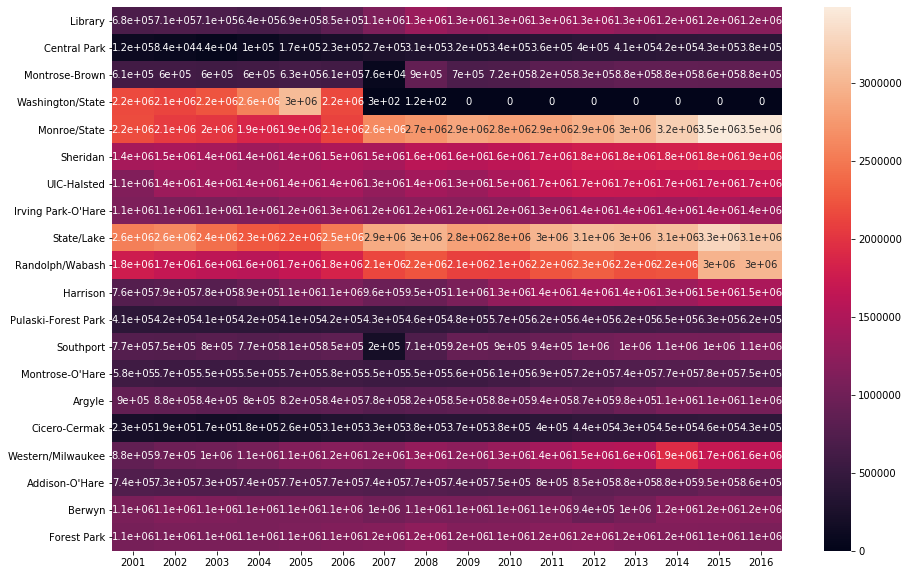

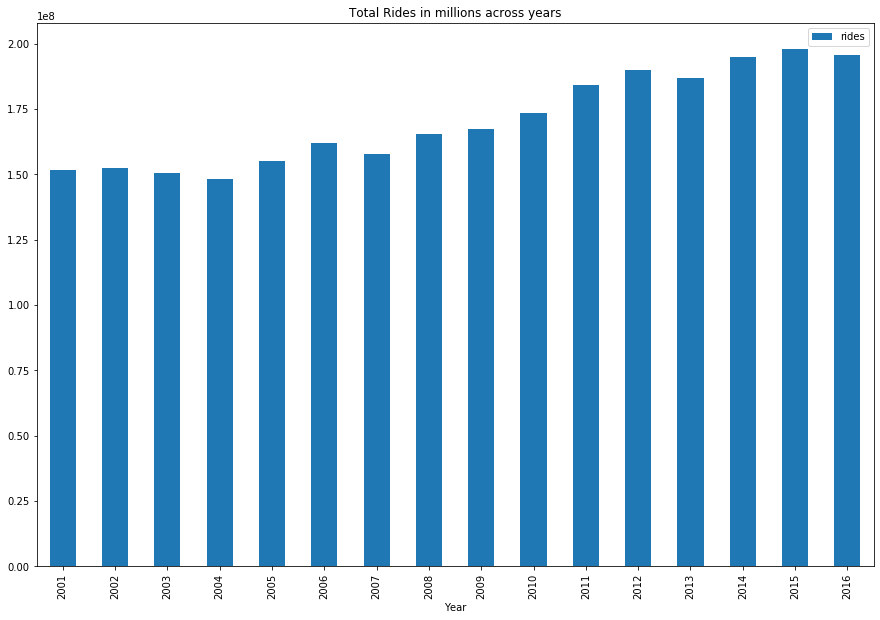

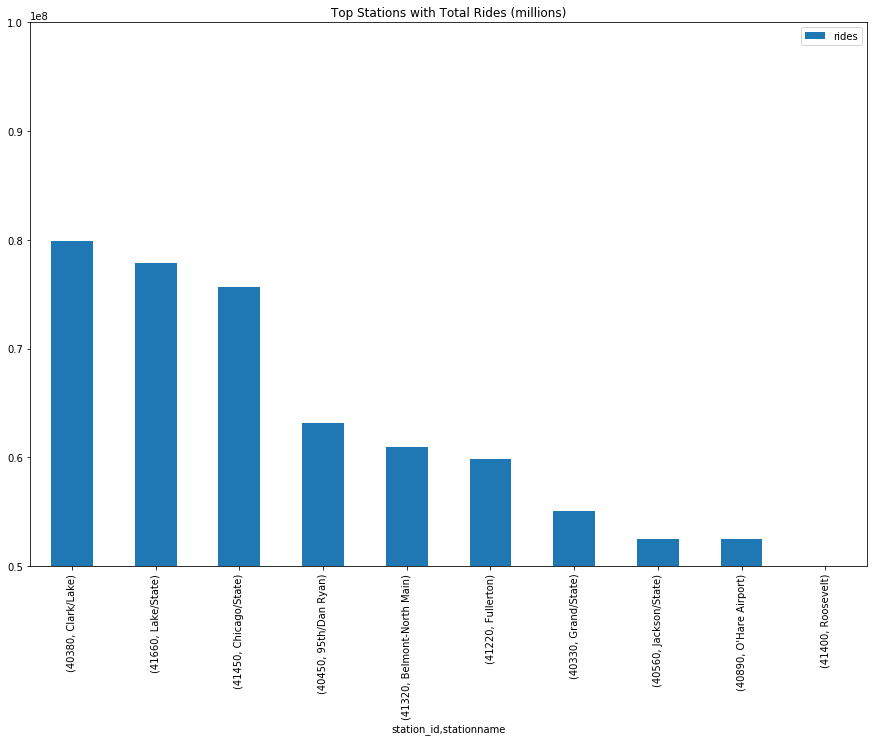

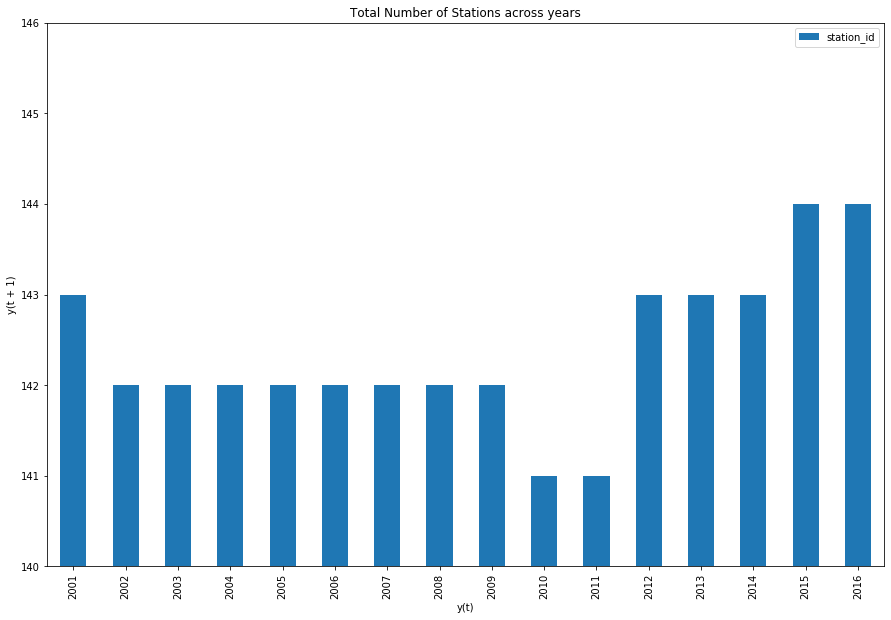


##########  Performing Result Repository Creation ############


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
40850


             ds        trend   yhat_lower   yhat_upper  trend_lower  \
5846 2017-01-01  3264.291950  -491.176087  1873.094558  3264.291950   
5847 2017-01-02  3264.100520  1630.626637  4135.606271  3264.100520   
5848 2017-01-03  3263.909091  1887.829874  4275.498034  3263.909091   
5849 2017-01-04  3263.717661  1917.977902  4267.221873  3263.717661   
5850 2017-01-05  3263.526232  1955.386401  4298.249535  3263.526232   
...         ...          ...          ...          ...          ...   
6206 2017-12-27  3195.377297  1612.993241  4027.637523  2926.839752   
6207 2017-12-28  3195.185868  1634.438340  4049.228351  2925.246798   
6208 2017-12-29  3194.994438  1169.180703  3529.500730  2923.653845   
6209 2017-12-30  3194.803009  -249.097729  2350.083529  2922.060891   
6210 2017-12-31  3194.611579  -654.728892  1819.218474  2920.467938   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
5846  3264.291950    -2624.213205          -2624.213205          -

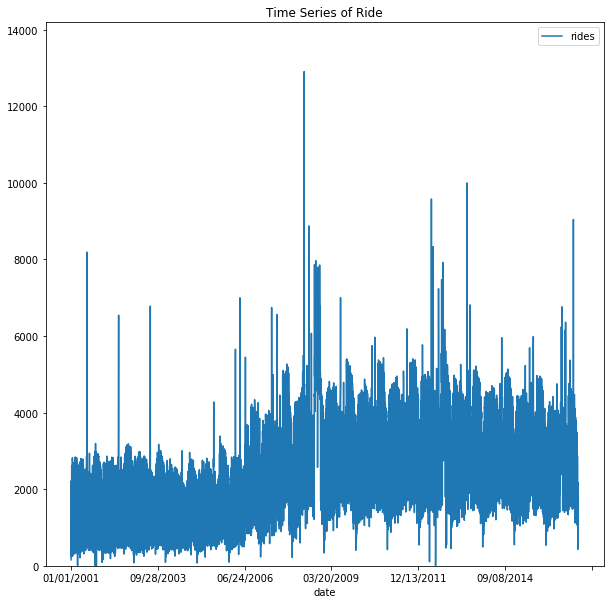

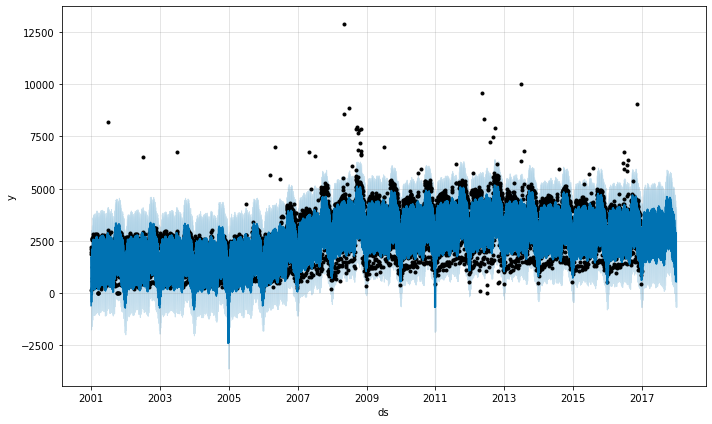

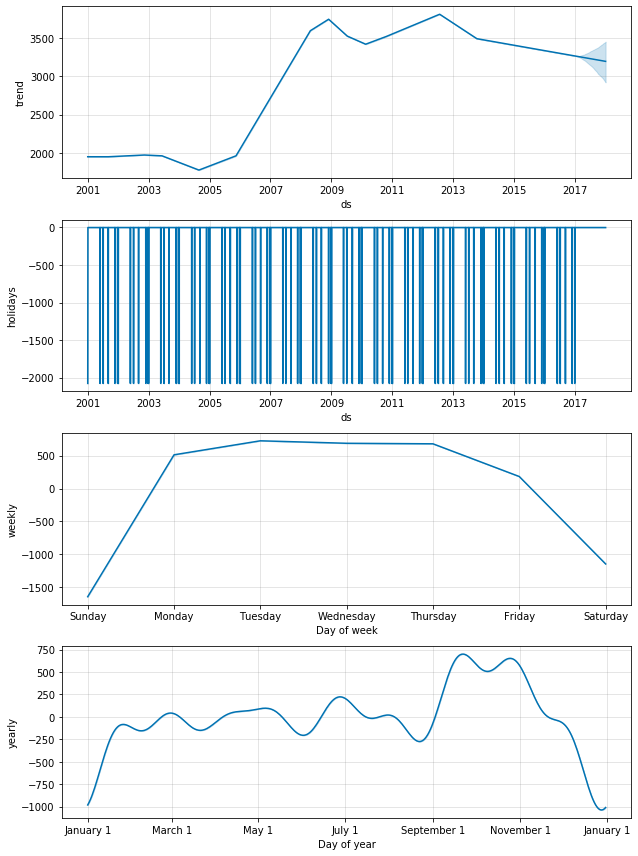

In [36]:
## Triggering Point
Master, Result_Repository, test_data = driver_function()

In [33]:
## Station-wise -> Forecasted Results
print(Result_Repository)

{40850:              ds        trend   yhat_lower   yhat_upper  trend_lower  \
5846 2017-01-01  3264.291950  -632.662945  1899.181300  3264.291950   
5847 2017-01-02  3264.100520  1620.972094  4011.974351  3264.100520   
5848 2017-01-03  3263.909091  1912.776166  4240.638012  3263.909091   
5849 2017-01-04  3263.717661  2034.973927  4319.581549  3263.717661   
5850 2017-01-05  3263.526232  1893.468352  4269.277823  3263.526232   
...         ...          ...          ...          ...          ...   
6206 2017-12-27  3195.377297  1642.565169  4082.854118  2915.046232   
6207 2017-12-28  3195.185868  1604.705537  3980.670407  2913.654182   
6208 2017-12-29  3194.994438  1138.673032  3693.740905  2912.262131   
6209 2017-12-30  3194.803009  -113.937488  2267.768706  2910.870081   
6210 2017-12-31  3194.611579  -593.484721  1773.388068  2909.478030   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
5846  3264.291950    -2624.213205          -2624.213205   

In [34]:
forecast_stationid = 40850

In [35]:
## Parameter-1
'''
CHANGEPOINT_RANGE           = 0.95 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .005 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity

'''

evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  460.4880786911117
 ### MSE  ###  479552.9835285568
 ### RMSE ###  692.497641532848
 ### MAPE ###  19.602423520096426


In [ ]:
#### Error Metrics ####
 ### MAE  ###  460.4880786911117
 ### MSE  ###  479552.9835285568
 ### RMSE ###  692.497641532848
 ### MAPE ###  19.602423520096426

In [40]:
## Parameter-2
'''
CHANGEPOINT_RANGE           = 0.8 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .005 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
'''

evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  473.9527304334557
 ### MSE  ###  492210.47089166014
 ### RMSE ###  701.5771311065236
 ### MAPE ###  20.04188543766972


In [ ]:
#### Error Metrics ####
 ### MAE  ###  473.9527304334557
 ### MSE  ###  492210.47089166014
 ### RMSE ###  701.5771311065236
 ### MAPE ###  20.04188543766972

In [46]:
############################################################################################
####     Parameter-3  ####
'''
CHANGEPOINT_RANGE           = 0.9 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .01 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
'''
##############################################################################################
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  382.20743477591776
 ### MSE  ###  418715.5673814665
 ### RMSE ###  647.082349768147
 ### MAPE ###  16.986805161846856


In [ ]:
#### Error Metrics ####
 ### MAE  ###  382.20743477591776
 ### MSE  ###  418715.5673814665
 ### RMSE ###  647.082349768147
 ### MAPE ###  16.986805161846856

In [51]:
'''
############################################################################################
####     Parameter-4  ####
CHANGEPOINT_RANGE           = 0.9 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .1 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''

evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  335.45264925819964
 ### MSE  ###  386382.2287680306
 ### RMSE ###  621.5965160520373
 ### MAPE ###  15.14522564342276


In [ ]:
#### Error Metrics ####
 ### MAE  ###  335.45264925819964
 ### MSE  ###  386382.2287680306
 ### RMSE ###  621.5965160520373
 ### MAPE ###  15.14522564342276

In [56]:
############################################################################################
####     Parameter-5  ####
'''
CHANGEPOINT_RANGE           = 0.9 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .5 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''

evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  336.8552950761256
 ### MSE  ###  387473.414141002
 ### RMSE ###  622.4736252573292
 ### MAPE ###  15.237717850763158


In [ ]:
#### Error Metrics ####
 ### MAE  ###  336.8552950761256
 ### MSE  ###  387473.414141002
 ### RMSE ###  622.4736252573292
 ### MAPE ###  15.237717850763158

In [61]:
############################################################################################
####     Parameter-6  ####
'''
CHANGEPOINT_RANGE           = 0.8 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .5 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  338.513465703338
 ### MSE  ###  388384.786458083
 ### RMSE ###  623.2052522709376
 ### MAPE ###  15.318261208279226


In [ ]:
#### Error Metrics ####
 ### MAE  ###  338.513465703338
 ### MSE  ###  388384.786458083
 ### RMSE ###  623.2052522709376
 ### MAPE ###  15.318261208279226

In [66]:
############################################################################################
####     Parameter-7  ####
CHANGEPOINT_RANGE           = 0.9 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .3 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  335.3398974509171
 ### MSE  ###  386295.1900734583
 ### RMSE ###  621.5264998963909
 ### MAPE ###  15.144616770226527


In [84]:
############################################################################################
####     Parameter-8  ####
'''
CHANGEPOINT_RANGE           = 0.9 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.99 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .25 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
'''
##############################################################################################
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  335.0996435690128
 ### MSE  ###  386072.72938740026
 ### RMSE ###  621.3475109690231
 ### MAPE ###  15.125882196873594


In [ ]:
###########################################################################################

In [77]:
forecast_stationid = 40780

In [36]:
## Parameter-1   ### Best View 
'''
############################################################################################
####     Parameter  ####
CHANGEPOINT_RANGE           = 0.8 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .001 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''

evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  218.39269353742048
 ### MSE  ###  119256.96444055022
 ### RMSE ###  345.3360167149529
 ### MAPE ###  35.199348908813015


In [ ]:
#### Error Metrics ####
 ### MAE  ###  218.39269353742048
 ### MSE  ###  119256.96444055022
 ### RMSE ###  345.3360167149529
 ### MAPE ###  35.199348908813015

In [42]:
############################################################################################
'''
####     Parameter-2  ####
CHANGEPOINT_RANGE           = 0.8 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .01 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''

evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  224.51568171678284
 ### MSE  ###  131274.97072161076
 ### RMSE ###  362.3188798856758
 ### MAPE ###  36.7761582806256


In [43]:
#### Error Metrics ####
 ### MAE  ###  224.51568171678284
 ### MSE  ###  131274.97072161076
 ### RMSE ###  362.3188798856758
 ### MAPE ###  36.7761582806256

In [50]:
'''
############################################################################################
####     Parameter-3  ####
CHANGEPOINT_RANGE           = 0.9 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .01 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  226.46203863016095
 ### MSE  ###  133489.83139891314
 ### RMSE ###  365.3626026277363
 ### MAPE ###  37.11508344764523


In [ ]:
#### Error Metrics ####
 ### MAE  ###  226.46203863016095
 ### MSE  ###  133489.83139891314
 ### RMSE ###  365.3626026277363
 ### MAPE ###  37.11508344764523

In [55]:
'''
############################################################################################
####     Parameter-4 ####
CHANGEPOINT_RANGE           = 0.9 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .1 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''

evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  247.66762161507216
 ### MSE  ###  95821.66558850836
 ### RMSE ###  309.5507480018557
 ### MAPE ###  33.29598103444917


In [ ]:
#### Error Metrics ####
 ### MAE  ###  247.66762161507216
 ### MSE  ###  95821.66558850836
 ### RMSE ###  309.5507480018557
 ### MAPE ###  33.29598103444917

In [61]:
'''
############################################################################################
####     Parameter-5  ####
CHANGEPOINT_RANGE           = 0.9 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .5 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  265.8317079142696
 ### MSE  ###  98813.72986691081
 ### RMSE ###  314.3465124141046
 ### MAPE ###  33.580099185013566


In [ ]:
#### Error Metrics ####
 ### MAE  ###  226.58908094088622
 ### MSE  ###  100395.84929394854
 ### RMSE ###  316.85304053132984
 ### MAPE ###  33.46590424074167

In [66]:
'''
############################################################################################
####     Parameter-6  ####
CHANGEPOINT_RANGE           = 0.8 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.99 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .25 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  226.58908094088622
 ### MSE  ###  100395.84929394854
 ### RMSE ###  316.85304053132984
 ### MAPE ###  33.46590424074167


In [ ]:
#### Error Metrics ####
 ### MAE  ###  226.58908094088622
 ### MSE  ###  100395.84929394854
 ### RMSE ###  316.85304053132984
 ### MAPE ###  33.46590424074167

In [72]:
'''
############################################################################################
####     Parameter-7  ####
CHANGEPOINT_RANGE           = 0.8 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .1 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  224.5360609357262
 ### MSE  ###  101798.86635221583
 ### RMSE ###  319.0593461289229
 ### MAPE ###  33.56252980758971


In [78]:
#### Error Metrics ####
 ### MAE  ###  224.5360609357262
 ### MSE  ###  101798.86635221583
 ### RMSE ###  319.0593461289229
 ### MAPE ###  33.56252980758971

In [79]:
'''
############################################################################################
####     Parameter-8  ####
CHANGEPOINT_RANGE           = 0.95 ## Change Points can also be specified by manual intervention 
                                ## Proportion of the Time-Series where potential change points are inferred
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) 
                                   ## around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
CHANGEPOINT_PRIOR_SCALE     = .1 ## Trend Flexibility 
                                   ## Increase -> More Flexibility 
                                   ## Decrease -> Increase Rigidity
##############################################################################################
'''
evaluation(forecast_stationid, Result_Repository, test_data)

#### Error Metrics ####
 ### MAE  ###  249.29219244385493
 ### MSE  ###  95896.63987533824
 ### RMSE ###  309.67182609229764
 ### MAPE ###  33.30777958873312
